# IAM 961 HW3

## Problem 1: Rayleigh Quotient iteration

Implement Rayleigh quotient iteration and demsontrate its convergence, as follows. 
Hint: develop and test your code using a small matrix (maybe 5 x 5). When you've got everything working, reset to a larger matrix (maybe 32 x 32, maybe 100 x 100) and recalculate from the beginning. 

Note: the line counts listed below are guidelines, not requirements. They're meant to let you know how roughly how much code each line should require. If you're writing more, you're working too hard. 

**Step 1**  Construct a random real symmetric $M \times M$ matrix $A$ with random but known eigenvalues and eigenvectors. Hint: construct $A$ from a random orthogonal matrix $V$ and a known random diagonal matrix $D$. (4 lines of code)

In [23]:
function gen_sym(m)
# Generates a random symmetric matrix with the given size m x m.
# Inputs:
# m - the size of the matrix
# Outputs:
# sym_mat - the symmetric matrix
# Q - the orthogonal matrix from the QR decomposition of V ( a random matrix)
# D - the random diagonal matrix
    
    # Generates a random vector ( sorted ) to use for the diagonal. 
    d = sort(rand(m), rev=true)
    # Makes the diagonal matrix
    D = diagm(d)
    # Generates a random m x m matrix
    V = rand(m,m)
    Q,R = qr(V)
    # Generates the symmetric matrix 
    sym_mat = Q*D*Q'
    return sym_mat,D,Q
end

gen_sym (generic function with 1 method)

In [24]:
function is_sym(mat, tol)
# Checks whether a matrix is symmetric within a given tolerance
# Inputs:
# mat - the (symmetric) matrix
# tol -  a given tolernace
# Outputs:
# check - boolean value for whether the matrix is symmetric
    sym = maximum(maximum(abs(mat-mat'))) 
    check = sym < tol
    return check
end

is_sym (generic function with 1 method)

In [25]:
m = 5
rand_sym ,D,Q = gen_sym(m)
tol = 1e-9
sym_check = is_sym(rand_sym,tol)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] abs(::Array{Float64,2}) at ./deprecated.jl:57
 [3] is_sym(::Array{Float64,2}, ::Float64) at ./In[24]:8
 [4] include_string(::String, ::String) at ./loading.jl:522
 [5] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /srv/julia/pkg/v0.6/IJulia/src/execute_request.jl:193
 [6] (::Compat.#inner#6{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /srv/julia/pkg/v0.6/Compat/src/Compat.jl:125
 [7] eventloop(::ZMQ.Socket) at /srv/julia/pkg/v0.6/IJulia/src/eventloop.jl:8
 [8] (::IJulia.##13#16)() at ./task.jl:335
while loading In[25], in expression starting on line 4


true

**Step 2** Select a diagonal element of $D$ and the corresponding column $V$, assigning them to variables $\lambda_t$ and $v_t$ (subscript $t$ stands for "true"). Verify numerically that these are an eigenvalue/eigenvector pair. (3 or 4 lines of code). 

In [26]:
function check_eigs(rand_sym, D, Q, eig_num, tol)
# Determines whether the true eigenvalue and eigenvector are the same within a given tolerance
# Inputs:
# rand_sym - the (symmetric) matrix
# D -  the diagonal matrix
# Q - the orthogonal matrix from the QR decomposition of V ( a random matrix)
# eig_num - the eigenvalue number 
# tol - tolerance to determine whether the true eigenvalue/eigenvector are the same
# Outputs:
# check - boolean value for whether the eigenvalues and eigenvectors are the same within tolerance
# v_t  - the true eigenvector
# lambda_t - the true eigenvalue
    
    # Gets the diagonal part of the diagonal matrix to get the true eigenvalue
    d = diag(D)
    lambda_t = d[eig_num]
    # Gets the true eigenvector
    v_t = Q[:,eig_num]
    
    # Performs the eigendecomposition
    lambda, V = eigs(rand_sym)
    lambda = real(lambda)[eig_num]
    v = real(V)[:, eig_num]
    # Checks whether v and lambda are v_t and lambda_t within tolerance
    check1 = norm(v_t-v) < tol
    check2 = norm(lambda_t - lambda) < tol
    
    check = check1 && check2
    
    return check, v_t, lambda_t
    
end

check_eigs (generic function with 1 method)

In [27]:
eig_num = 1 
eig_check, v_t,lambda_t = check_eigs(rand_sym, D, Q ,eig_num, tol)

(true, [-0.57716, -0.497868, -0.387705, -0.508303, -0.101622], 0.6297433251231568)

**Step 3** To get initial values for the Rayleigh quotient iteration, perturb the eigenvector by 20% or so, normalize it to unit length, and then evaluate the Rayleigh quotient. Use variable names $\lambda$ and $v$. (4 lines of code)

In [28]:
function perturbed(true_vec,perturbation )
# Generates the perturbed eigenvector 
# Inputs:
# perturbation - the amount to perturb the eigenvector
# Outputs:
# perturb_v - the perturbed eigenvector (normalized)
    perturb_v = true_vec+ rand(m)*perturbation
    perturb_v = perturb_v/norm(perturb_v)
    
    return perturb_v
end

perturbed (generic function with 1 method)

In [29]:
function rayleigh(A, x0, tol, numiter)
# Finds the eigenvalues through the Rayleigh iteration 
# Inputs:
# A - the matrix to find the eigenvector for 
# x0 - tolerance to find the eigenvector
# tol - parameter from inverse iteration that is updated
# numiter - a random initial vector
# Ouputs:
# sigma - parameter used in inverse iteration to accelerate convergence
# x - the eigenvector (1st)
# iter - the iteration it breaks on
    m,n = size(A)
    @assert( m == n, "Matrix A is not square")
    I = eye(n,n)
    sigma0 = 0
    x = x0
    
    for i in range(1,numiter)
        iter = i
        sigma = dot(x,A*x)/norm(x)^2
        xhat = (A-sigma*I)\x
        x = xhat/norm(xhat)
        if norm((A- sigma*I)*x) < tol
            return sigma, x, iter
            
        end
        
    end
    
    return sigma, x, iter
end 

rayleigh (generic function with 1 method)

In [30]:
mu = .5
epsilon = 1e-13
perturb_v = perturbed(v_t,0.2)
sigma, x, iter = rayleigh(rand_sym, perturb_v, epsilon, 200)

(0.6297433251231571, [0.57716, 0.497868, 0.387705, 0.508303, 0.101622], 4)

**Step 4** Now write a loop to do the Rayleigh quotient iteration. Stop when 
$\| A v - \lambda v\| < 10^{-13}$. Before the loop and at each step, compute the norm of the error in both the eigenvalue and eigenvector, and save into a vector for later plotting. (10 lines of code)

In [31]:
function rayleigh_mod(A, x0, tol, numiter,true_vec)
# Finds the eigenvalues through the Rayleigh iteration 
# Inputs:
# A - the matrix to find the eigenvector for 
# x0 - tolerance to find the eigenvector
# tol - parameter from inverse iteration that is updated
# numiter - a random initial vector
# true_vec - the true eigenvector
# Ouputs:
# sigma - parameter used in inverse iteration to accelerate convergence
# x - the eigenvector (1st)
# iter - the iteration it breaks on
    m,n = size(A)
    @assert( m== n, "Matrix A is not square")
    I = eye(n,n)
    sigma0 = 0
    x = x0
    lambda = true_vec[1]
    eigvec_error = zeros(numiter)
    eigval_error = zeros(numiter)
    for i in range(1,numiter)
        iter = i
        sigma = dot(x,A*x)/norm(x)^2
        xhat = (A-sigma*I)\x
        x = xhat/norm(xhat)
        eigvec_error[i] = norm(true_vec - x)
        eigval_error[i] = norm(lambda - x[1])
        if norm((A- sigma*I)*x) < tol
            
            return eigvec_error, eigval_error, iter
            
        end
        
    end
    
    return eigvec_error, eigval_error, iter
end 

rayleigh_mod (generic function with 1 method)

In [42]:
numiter =200
eigvec_error, eigval_error, iter = rayleigh_mod(rand_sym, perturb_v, epsilon, numiter, v_t);

**Step 5** Plot the errors in the eigenvalue and eigenvector as a function of the iteration number, together in one plot. The Rayleigh quotient iteration code takes about 3 lines of code, the plotting more. Don't forget to label your axes and provide a legend. 
(5 lines of code).

In [70]:
function error_filter(array)
# a filter for the error vectors 
# Inputs:
# array - a vector
# Outputs:
# filtered_array - select non-zero elements which are less than 1
    
    filtered_array =filter( x -> x <1 && x != 0, array)
    return filtered_array
end

error_filter (generic function with 1 method)

In [45]:
using PyPlot

In [71]:
function error_plot(eigvec_error, eigval_error)
# plots the eigenevector and eigenvalue error
    filtered_eigvec = error_filter(eigvec_error)
    filtered_eigval = error_filter(eigval_error)
    
    l = length(filtered_eigvec)
    my_range = 1:1:l
    plot(my_range, filtered_eigvec)
    plot(my_range, filtered_eigval)
    title("Error vs # of Iterations")
    xlabel("Iterations")
    ylabel("Error")
    
end
 

error_plot (generic function with 1 method)

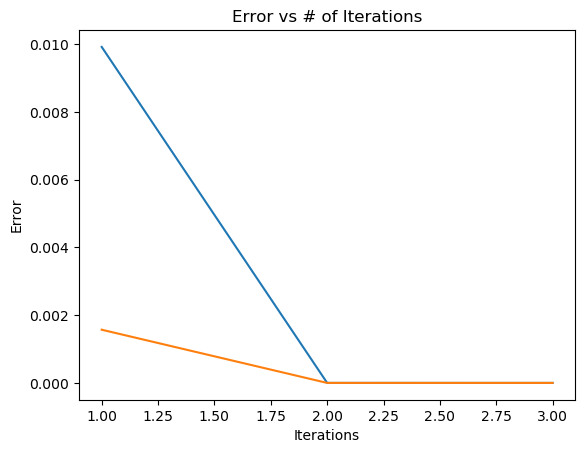

PyObject Text(24.0, 0.5, 'Error')

In [72]:
error_plot(eigvec_error, eigval_error)

**Questions** (a) Are you amazed, or what? (b) Can you confirm that the errors scale as stated on page 208 of Trefethen and Bau?

(a) Yes
(b) The scale looks correct

## Problem 2: GMRES

Implement GMRES and investigate its convergence as a function of the matrix condition number, as follows. 

**Step 1** Construct a random real $M \times M$ matrix $A$ with condition $\kappa$ and exponentially graded singular values $\sigma_n = \kappa^{-(n-1)/(M-1)}$. For testing start with $M=5$ and $\kappa = 10^4$.

In [64]:
function random_cond_matrix(kappa,m)
# Generates a random m x m matrix with given condition number
# Inputs:
# kappa -  the condition number
# m - the size of the matrix
# Outputs:
# cond_matrix - the random matrix with given condition number

    sigma_range = 0:1:m-1
    sigma_k = -1.0*sigma_range/(m-1)
    sigma_k = kappa.^sigma_k
    S = diagm(sigma_k)
    V = rand(m,m)
    Q,R = qr(V)

    cond_matrix = Q*S*Q'
    return cond_matrix

end

random_cond_matrix (generic function with 1 method)

In [68]:
kappa = 10^4
m = 5

A = random_cond_matrix(kappa, m);

**Step 2** Let $x$ be a random M vector with normally-distributed components, and let $b = A x$.

In [69]:
x = rand(m)
b = A*x;

5-element Array{Float64,1}:
 0.00996541
 0.304966  
 0.152349  
 0.247785  
 0.0253963 

**Step 3** Implement GMRES iteration to approximate the solution of $Ax=b$ within the succession of Krylov subspaces. Save the normalized residual $\| A x_n - b\|/\|b\|$ and the normalized $x$ error $\| x_n - x \|$ at each step $n$ of the iteration for later plotting.

Your GMRES code should go all the way to $n=M$ iterations. Your code should have a for-loop to handle iterations $n=1$ to $M-1$ followed by some special-case code to handle the last $n=M$th iterate, since the last iteration works a little differently. 

**Step 4** Once your code is working (the residual is $10^{-14}$ or $10^{-15}$ at the last iterate), set $M$ to a moderately small number like 100 and produce two plots, one of residual versus $n$, and one of $x$ error versus $n$. On each plot, overlay results for $\kappa=10^4$ and $\kappa=10^{16}$.

Discuss your results. Is anything surprising? What can you explain about the behavior of the plots, given what you know about GMRES and $Ax=b$ problems in general?